In [1]:
# Auxiliaries (Importing Datafile, Checking Time)
import os 
import time

# Calculations
import numpy as np

# For Importing Data Files
import pandas as pd
import glob

# For Data Visualization
import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np
from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu
from skimage import color

# For Image Pre-Processing
import cv2

# Create dataframe

3 columns
1. Disease Classification
2. Image Name
3. Image RGB Values (RGB Converted from BGR)

In [2]:
def natural_sort_key(s):
    """Key function for natural sorting."""
    import re
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def create_dataframe_from_folders(root_folder):
    # Initialize empty lists to store data for each column
    folder_names = []
    photo_names = []
    photos = []

    # Traverse through the root folder and its subfolders
    for folder_name in sorted(os.listdir(root_folder)):
        folder_path = os.path.join(root_folder, folder_name)

        # Check if the entry in the root folder is a directory
        if os.path.isdir(folder_path):
            for photo_name in sorted(os.listdir(folder_path), key=natural_sort_key):
                # Assuming photos are in common image formats (e.g., jpg, png)
                if photo_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    photo_path = os.path.join(folder_path, photo_name)

                    # Read image data using cv2
                    image_data = cv2.imread(photo_path)

                    # Convert BGR to RGB
                    image_data_rgb = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

                    # Append data to the lists
                    folder_names.append(folder_name)
                    photo_names.append(photo_name)
                    photos.append(image_data_rgb)

    # Create a DataFrame
    df = pd.DataFrame({
        'class': folder_names,
        'img_name': photo_names,
        'rgb': photos
    })

    return df

Get data frame 

In [3]:
# Example usage:
extra_resized_folder_path = r"C:\Users\Josh\000 Files\003 Mengg AI\01a 201 (AI)\03 Mini-Project\resized_raw_images (14 Classes - Zoomed)"
extra_resized = create_dataframe_from_folders(extra_resized_folder_path)

# Display the resulting DataFrame
print(extra_resized.head())

                   class            img_name  \
0  bacterial_leaf_blight  BLB_single (1).jpg   
1  bacterial_leaf_blight  BLB_single (2).jpg   
2  bacterial_leaf_blight  BLB_single (3).jpg   
3  bacterial_leaf_blight  BLB_single (4).jpg   
4  bacterial_leaf_blight  BLB_single (5).jpg   

                                                 rgb  
0  [[[161, 125, 67], [163, 128, 70], [166, 132, 7...  
1  [[[238, 229, 222], [238, 229, 222], [238, 229,...  
2  [[[236, 225, 219], [237, 226, 220], [238, 227,...  
3  [[[236, 223, 217], [236, 223, 217], [237, 224,...  
4  [[[236, 225, 221], [236, 225, 221], [236, 225,...  


**Class Counts**

In [4]:
class_counts = extra_resized['class'].value_counts()

print(class_counts)

class
brown_spot               54
rice_blast               52
rice_false_smut          51
bacterial_leaf_streak    50
grassy_stunt_virus       50
healthy_rice_plant       50
narrow_brown_spot        50
sheath_blight            50
sheath_rot               50
stem_rot                 50
tungro_virus             50
bakanae                  49
ragged_stunt_virus       49
bacterial_leaf_blight    48
Name: count, dtype: int64


# Feature Extraction

## Texture Features

In [5]:
import pandas as pd
import numpy as np
import mahotas
from itertools import product
import time

def compute_glcm_features(df):
    df['gray'] = df['rgb'].apply(lambda x: cv2.cvtColor(np.uint8(x), cv2.COLOR_RGB2GRAY))
    def calculate_glcm(gray_image):
        # Compute GLCM using mahotas
        glcm = mahotas.features.haralick(gray_image.astype(np.uint8), ignore_zeros=True)
        return glcm.mean(axis=0)

    features = []

    start_time = time.time()
    
    for index, row in df.iterrows():
        gray_image = row['gray']
        glcm_features = calculate_glcm(gray_image)
        features.append(glcm_features)

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Define meaningful column names for GLCM features
    glcm_columns = [
        'Angular Second Moment',
        'Contrast',
        'Correlation',
        'Sum of Squares: Variance',
        'Inverse Difference Moment',
        'Sum Average',
        'Sum Variance',
        'Sum Entropy',
        'Entropy',
        'Difference Variance',
        'Difference Entropy',
        'Informational Measure of Correlation 1',
        'Informational Measure of Correlation 2'
    ]

    # Create a DataFrame with the new GLCM features and meaningful column names
    glcm_df = pd.DataFrame(features, columns=[f'GLCM_{col}' for col in glcm_columns])

    # Concatenate the new DataFrame with the original DataFrame
    result_df = pd.concat([df, glcm_df], axis=1)

    print(f"Elapsed Time: {elapsed_time:.2f} seconds")

    return result_df

In [6]:
glcm = compute_glcm_features(extra_resized)

Elapsed Time: 17.18 seconds


In [7]:
# Remove the first n columns
f_glcm = glcm.iloc[:, 4:]

In [8]:
f_glcm.head()

,GLCM_Angular Second Moment,GLCM_Contrast,GLCM_Correlation,GLCM_Sum of Squares: Variance,GLCM_Inverse Difference Moment,GLCM_Sum Average,GLCM_Sum Variance,GLCM_Sum Entropy,GLCM_Entropy,GLCM_Difference Variance,GLCM_Difference Entropy,GLCM_Informational Measure of Correlation 1,GLCM_Informational Measure of Correlation 2
0,0.000358,266.001841,0.964868,3785.238579,0.239492,180.814209,14874.952473,8.629918,12.466566,0.000331,4.343470,-0.369462,0.997668
1,0.018832,29.540256,0.994057,2484.910874,0.515623,370.827844,9910.103241,6.141836,8.088455,0.000993,2.749243,-0.444118,0.993843
2,0.012217,47.934937,0.991704,2888.983700,0.439836,355.884272,11507.999864,6.346219,8.658163,0.000813,3.050238,-0.405166,0.991940
3,0.019039,56.672401,0.992339,3697.472233,0.519511,348.227408,14733.216531,6.472970,8.465276,0.000997,2.890223,-0.465543,0.996049
4,0.025665,45.344059,0.993331,3397.524613,0.590942,379.393294,13544.754392,5.682043,7.201895,0.001234,2.390516,-0.478429,0.993598


## Histogram Features

In [9]:
import cv2
import numpy as np
from skimage import color
from sklearn.preprocessing import normalize

In [10]:
def values(dataframe):
    # Ensure the 'rgb' column exists in the dataframe
    dataframe['hsv'] = dataframe['rgb'].apply(lambda x: cv2.cvtColor(np.uint8(x), cv2.COLOR_RGB2HSV))
    #dataframe['hsi'] = dataframe['rgb'].apply(lambda x: color.rgb2hsi(np.uint8(x)))
    dataframe['lab'] = dataframe['rgb'].apply(lambda x: cv2.cvtColor(np.uint8(x), cv2.COLOR_RGB2LAB))

    dataframe['red'] = dataframe['rgb'].apply(lambda rgb: rgb[:,:,0])
    dataframe['green'] = dataframe['rgb'].apply(lambda rgb: rgb[:,:,1])
    dataframe['blue'] = dataframe['rgb'].apply(lambda rgb: rgb[:,:,2])
    
    dataframe['hue_v'] = dataframe['hsv'].apply(lambda hsv: hsv[:,:,0])
    dataframe['saturation_v'] = dataframe['hsv'].apply(lambda hsv: hsv[:,:,1])
    dataframe['value_v'] = dataframe['hsv'].apply(lambda hsv: hsv[:,:,2])
    
    #dataframe['hue_i'] = dataframe['hsv'].apply(lambda hsi: hsi[:,:,0])
    #dataframe['saturation_i'] = dataframe['hsv'].apply(lambda hsi: hsi[:,:,1])
    #dataframe['intensity_i'] = dataframe['hsv'].apply(lambda hsi: hsi[:,:,2])
    
    dataframe['lightness'] = dataframe['lab'].apply(lambda lab: lab[:, :, 0])
    dataframe['a'] = dataframe['lab'].apply(lambda lab: lab[:, :, 1])
    dataframe['b'] = dataframe['lab'].apply(lambda lab: lab[:, :, 2])

    return dataframe

In [11]:
import pandas as pd
import numpy as np

def add_bins_to_dataframe(dataframe, column_name, num_bins):
    # Extract the specified column
    original_column = dataframe[column_name]

    # Define bin edges based on the min and max values in the matrices
    min_value = np.min([np.min(matrix) for matrix in original_column])
    max_value = np.max([np.max(matrix) for matrix in original_column])

    bin_edges = np.linspace(min_value, max_value, num_bins + 1)

    # Create column names for the bins
    bin_column_names = [f'{column_name}_{i}' for i in range(num_bins)]

    # Iterate through each matrix in the original column
    for i, matrix in enumerate(original_column):
        # Digitize each element in the matrix into the corresponding bin
        bin_indices = np.digitize(matrix.flatten(), bin_edges, right=True)

        # Count the occurrences of each bin index
        bin_counts = np.bincount(bin_indices, minlength=num_bins + 1)[1:]

        # Add new columns to the DataFrame for each bin
        for j, bin_column_name in enumerate(bin_column_names):
            dataframe.loc[i, bin_column_name] = bin_counts[j]

    return dataframe

In [12]:
channels = values(extra_resized)

In [13]:
import pandas as pd
import numpy as np

def create_bins_dataframe(dataframe, col, num_bins):
    bins_dataframe = pd.DataFrame()

    #print(col)
    min_value = np.min([np.min(matrix) for matrix in dataframe[col]])
    max_value = np.max([np.max(matrix) for matrix in dataframe[col]])

    bin_edges = np.linspace(min_value, max_value, num_bins + 1)
    bin_column_names = [f'{col}_{i}' for i in range(1, num_bins + 1)]

    for matrix in dataframe[col]:
        bin_indices = np.digitize(matrix.flatten(), bin_edges, right=True)
        bin_counts = np.bincount(bin_indices, minlength=num_bins + 1)[1:]

        bins_dataframe = pd.concat([bins_dataframe, pd.DataFrame(bin_counts).transpose()], axis=0, ignore_index=True)

    bins_dataframe.columns = bin_column_names
        
    return bins_dataframe

def hist_features(df, cols, bins):
    complete_bins = pd.DataFrame()

    for col in cols:
        col_bins = create_bins_dataframe(df, col, bins)
        complete_bins = pd.concat([complete_bins, col_bins], axis=1)

    return complete_bins

cols = ['red', 'green', 'blue', 'hue_v', 'saturation_v', 'value_v', 'lightness', 'a', 'b']

In [14]:
# Assuming 'channels' is your DataFrame
f_histogram = hist_features(channels, cols, 82)

In [15]:
f_histogram.head()

,red_1,red_2,red_3,red_4,red_5,red_6,red_7,red_8,red_9,red_10,...,b_73,b_74,b_75,b_76,b_77,b_78,b_79,b_80,b_81,b_82
0,175,390,373,484,879,1088,1006,1012,832,1121,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Color Moments Features

In [16]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import cv2

def color_moments(dataframe, cols):
    for col in cols:
        print(col)
        mean_values = []
        variance_values = []
        kurtosis_values = []
        skewness_values = []

        for img in dataframe[col]:
            # Assuming 'img' is a 3D numpy array representing an RGB image
            # Calculate statistics for each image
            mean_channel = np.mean(img, axis=(0, 1))
            variance_channel = np.var(img, axis=(0, 1))
            kurtosis_channel = kurtosis(img, axis=(0, 1))
            skewness_channel = skew(img, axis=(0, 1))

            # Append values to respective lists
            mean_values.append(mean_channel)
            variance_values.append(variance_channel)
            kurtosis_values.append(kurtosis_channel)
            skewness_values.append(skewness_channel)

        # Add the new columns to the DataFrame with channel names
        for i in range(img.shape[2]):  # Assuming 'img' has shape (height, width, channels)
            dataframe[f'{col}_channel_{i}_mean'] = [x[i] for x in mean_values]
            dataframe[f'{col}_channel_{i}_variance'] = [x[i] for x in variance_values]
            dataframe[f'{col}_channel_{i}_kurtosis'] = [x[i] for x in kurtosis_values]
            dataframe[f'{col}_channel_{i}_skewness'] = [x[i] for x in skewness_values]
    
    return dataframe

In [17]:
color_df = color_moments(extra_resized, ['rgb','hsv','lab'])

rgb
hsv
lab


In [18]:
f_color = color_df.drop(columns=['class','img_name','rgb','gray','hsv','lab','red','green','blue', 'hue_v', 'saturation_v', 'value_v', 'lightness', 'a', 'b'])

In [19]:
f_color.head()

,rgb_channel_0_mean,rgb_channel_0_variance,rgb_channel_0_kurtosis,rgb_channel_0_skewness,rgb_channel_1_mean,rgb_channel_1_variance,rgb_channel_1_kurtosis,rgb_channel_1_skewness,rgb_channel_2_mean,rgb_channel_2_variance,...,lab_channel_0_kurtosis,lab_channel_0_skewness,lab_channel_1_mean,lab_channel_1_variance,lab_channel_1_kurtosis,lab_channel_1_skewness,lab_channel_2_mean,lab_channel_2_variance,lab_channel_2_kurtosis,lab_channel_2_skewness
0,96.270089,3990.031165,-0.411904,0.744936,91.700953,3810.139266,-0.052213,0.715675,66.826531,4130.342437,...,-0.306373,0.581436,125.893136,75.606086,1.887396,0.218237,142.877770,139.253973,-0.707640,0.418429
1,199.242566,2069.785490,-1.514378,-0.515288,187.317861,2008.205226,-1.781474,-0.309983,139.516861,7895.016537,...,-1.728330,-0.350443,126.572007,37.250356,-0.824629,-0.589908,153.407805,516.292401,-1.853678,0.254570
2,186.096600,3007.509502,-1.814930,-0.218978,182.329321,2194.281216,-1.800756,-0.187194,135.049247,7673.218019,...,-1.818788,-0.189757,122.807617,76.436941,-1.666075,-0.225414,152.541653,431.494438,-1.912749,0.151626
3,183.299904,3966.247111,-1.576733,-0.496616,176.301718,3005.669150,-1.622519,-0.438570,139.876574,7783.860065,...,-1.594524,-0.460021,125.340880,60.401777,-0.872360,-0.856840,147.570592,328.878308,-1.485259,0.609684
4,195.866789,3836.636711,-1.119386,-0.906572,191.531848,2688.568262,-1.122789,-0.898519,164.997409,6832.874435,...,-1.123964,-0.901373,125.377272,71.134292,-0.437482,-1.166782,142.234515,262.144242,-0.463300,1.184542


## Zernike Features

In [20]:
import cv2
import mahotas.features
import numpy as np
import pandas as pd

def zernike(df, zernike_order):
    features_list = []

    for idx, row in df.iterrows():
        gray_img = row['gray']

        # Check if the image is grayscale
        if len(gray_img.shape) == 2:
            # If grayscale, compute Zernike moments directly
            moments = mahotas.features.zernike_moments(gray_img, radius=zernike_order)
        else:
            raise ValueError("Input image must be grayscale.")

        features_list.append(moments)

    # Determine the number of features per image
    num_features_per_image = len(features_list[0])

    # Add features to the DataFrame
    feature_columns = [f'feature_{i}' for i in range(num_features_per_image)]
    df_features = pd.DataFrame(features_list, columns=feature_columns)
    df_result = pd.concat([df, df_features], axis=1)

    return df_result

In [21]:
zernike_df = zernike(extra_resized, 10)
f_zernike = zernike_df.iloc[:, 51:]
f_zernike.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,0.31831,0.015994,0.005830,0.004560,0.010091,0.015493,0.014889,0.002006,0.005715,0.019349,...,0.002224,0.019971,0.032080,0.029382,0.009788,0.019124,0.006777,0.016389,0.011934,0.013850
1,0.31831,0.001594,0.004247,0.003555,0.011316,0.010798,0.020522,0.017677,0.027740,0.014565,...,0.024135,0.019143,0.020336,0.016388,0.015845,0.003558,0.002029,0.007313,0.008196,0.024526
2,0.31831,0.005007,0.008705,0.006788,0.019123,0.016181,0.003956,0.002548,0.003154,0.013875,...,0.007416,0.025023,0.029394,0.028356,0.004316,0.020854,0.006702,0.015855,0.013115,0.013213
3,0.31831,0.015932,0.063308,0.051655,0.003087,0.017435,0.015274,0.036561,0.007757,0.015761,...,0.001233,0.033839,0.026412,0.008598,0.007508,0.004111,0.003043,0.041183,0.010187,0.023167
4,0.31831,0.003166,0.010777,0.007619,0.004912,0.010917,0.014197,0.007375,0.009341,0.004156,...,0.002502,0.008668,0.026115,0.033828,0.006642,0.002440,0.006141,0.001619,0.005364,0.005747


## Legendre Moments

In [22]:
#extra_resized.head()

In [23]:
l_input = extra_resized.drop(columns=['class','hsv','lab','red','green','blue', 'hue_v', 'saturation_v', 'value_v', 'lightness', 'a', 'b'])
l_input = l_input.iloc[:, :4]

In [24]:
l_input.head()

,img_name,rgb,gray,rgb_channel_0_mean
0,BLB_single (1).jpg,"[[[161, 125, 67], [163, 128, 70], [166, 132, 7...","[[129, 132, 135, 136, 136, 138, 139, 139, 137,...",96.270089
1,BLB_single (2).jpg,"[[[238, 229, 222], [238, 229, 222], [238, 229,...","[[231, 231, 231, 231, 230, 229, 230, 230, 229,...",199.242566
2,BLB_single (3).jpg,"[[[236, 225, 219], [237, 226, 220], [238, 227,...","[[228, 229, 230, 231, 231, 231, 230, 229, 230,...",186.096600
3,BLB_single (4).jpg,"[[[236, 223, 217], [236, 223, 217], [237, 224,...","[[226, 226, 227, 227, 227, 227, 227, 227, 227,...",183.299904
4,BLB_single (5).jpg,"[[[236, 225, 221], [236, 225, 221], [236, 225,...","[[228, 228, 228, 228, 228, 228, 228, 228, 228,...",195.866789


In [25]:
import numpy as np
import pandas as pd
import cv2
from scipy.special import legendre

def compute_legendre_features(rgb_image, degree):
    # Get V channel from RGB image
    v_channel = rgb_image[:, :, 2]

    # Define x and y coordinates
    x_size, y_size = v_channel.shape
    x = np.linspace(-1, 1, x_size)
    y = np.linspace(-1, 1, y_size)

    # Compute Legendre features for the V channel
    legendre_features = np.zeros((degree + 1, degree + 1))

    for j in range(degree + 1):
        for k in range(degree + 1):
            legendre_features[j, k] = np.sum(v_channel * legendre(j)(x) * legendre(k)(y))

    return legendre_features.flatten()

def add_legendre(df, degree):
    # Create a new DataFrame for Legendre features
    legendre_columns = [f'v_legendre_{i}_{j}' for i in range(degree + 1) for j in range(degree + 1)]
    legendre_df = pd.DataFrame(df['rgb'].apply(lambda rgb: compute_legendre_features(rgb, degree)).values.tolist(), columns=legendre_columns)

    # Concatenate the new DataFrame with the original DataFrame
    result_df = pd.concat([df, legendre_df], axis=1)

    return result_df

In [26]:
legendre_df = add_legendre(l_input, 10)

In [27]:
f_legendre = legendre_df.iloc[:, 4:]
f_legendre.head()

,v_legendre_0_0,v_legendre_0_1,v_legendre_0_2,v_legendre_0_3,v_legendre_0_4,v_legendre_0_5,v_legendre_0_6,v_legendre_0_7,v_legendre_0_8,v_legendre_0_9,...,v_legendre_10_1,v_legendre_10_2,v_legendre_10_3,v_legendre_10_4,v_legendre_10_5,v_legendre_10_6,v_legendre_10_7,v_legendre_10_8,v_legendre_10_9,v_legendre_10_10
0,3353088.0,-1.087238e+06,235099.508778,138969.614640,-213880.081800,32868.044026,41100.147021,-22057.604276,4093.363361,4959.005446,...,-6311.718764,17134.386705,-4354.325125,21434.136965,-4999.513654,-16770.059701,9646.856903,18634.297732,-77270.510962,171556.758187
1,7000398.0,-1.647153e+05,16993.528324,1784.367334,35445.715279,-2965.453418,31875.111977,-940.235712,29365.092505,-4259.342104,...,-3207.796386,32476.086937,-2489.962161,33577.290543,-2410.030008,34908.447337,-1957.168143,33858.993532,-14522.080791,367208.435549
2,6776231.0,-4.040194e+04,94178.452151,-28337.376132,38294.200615,2442.323361,29519.886739,573.809983,32319.438140,-2597.708766,...,-2207.567426,34574.201478,-962.117115,34265.410875,-840.786748,35865.336257,-4235.821516,42533.736921,-5801.509097,361853.335579
3,7018447.0,9.445593e+04,6862.907016,4972.047285,39488.004341,2049.562175,27225.615815,-3893.297024,36188.794809,4373.071135,...,3169.501812,34547.292349,401.307337,33508.846870,1111.812538,35333.013038,1912.006198,33394.064995,8572.133821,367697.941762
4,8278910.0,-7.859323e+04,13974.904824,924.369355,43248.444176,-1325.024786,36822.544836,-309.008812,39155.165133,-2002.215996,...,-1352.400608,40153.183075,-1015.441145,40220.085810,-1162.845594,41754.143653,-913.967013,39824.164348,-6934.850970,434175.385973


## Complete Features

In [28]:
# Create a new DataFrame with just the selected column
classes = pd.DataFrame(extra_resized['class'])

In [29]:
#complete_features = pd.concat([classes,f_color,f_histogram, f_glcm], axis=1)
complete_features = pd.concat([classes,f_histogram, f_glcm, f_color, f_legendre, f_zernike], axis=1)

In [30]:
complete_features.head()

,class,red_1,red_2,red_3,red_4,red_5,red_6,red_7,red_8,red_9,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,bacterial_leaf_blight,175,390,373,484,879,1088,1006,1012,832,...,0.002224,0.019971,0.032080,0.029382,0.009788,0.019124,0.006777,0.016389,0.011934,0.013850
1,bacterial_leaf_blight,0,0,0,0,0,0,0,0,0,...,0.024135,0.019143,0.020336,0.016388,0.015845,0.003558,0.002029,0.007313,0.008196,0.024526
2,bacterial_leaf_blight,0,0,0,0,0,0,0,0,0,...,0.007416,0.025023,0.029394,0.028356,0.004316,0.020854,0.006702,0.015855,0.013115,0.013213
3,bacterial_leaf_blight,0,0,0,0,0,0,0,0,0,...,0.001233,0.033839,0.026412,0.008598,0.007508,0.004111,0.003043,0.041183,0.010187,0.023167
4,bacterial_leaf_blight,0,0,0,0,0,0,0,0,0,...,0.002502,0.008668,0.026115,0.033828,0.006642,0.002440,0.006141,0.001619,0.005364,0.005747


# Data Normalization and One Hot Encoding

In [31]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def normalize_dataframe(df):
    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Extract numerical columns (assuming only numerical columns need normalization)
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

    # Apply normalization to each numerical column
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

In [32]:
normalized_features = normalize_dataframe(complete_features)
normalized_features.head()

,class,red_1,red_2,red_3,red_4,red_5,red_6,red_7,red_8,red_9,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,bacterial_leaf_blight,0.015877,0.032128,0.03783,0.02203,0.135732,0.095615,0.138263,0.314286,0.283572,...,0.015064,0.144965,0.223467,0.219293,0.061088,0.135918,0.056597,0.158638,0.092182,0.116852
1,bacterial_leaf_blight,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.182499,0.138646,0.139402,0.121577,0.099206,0.025037,0.015334,0.066894,0.061873,0.212293
2,bacterial_leaf_blight,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.054738,0.183517,0.204241,0.211581,0.026646,0.148234,0.055950,0.153247,0.101754,0.111160
3,bacterial_leaf_blight,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.007488,0.250792,0.182894,0.062999,0.046734,0.028980,0.024150,0.409268,0.078012,0.200142
4,bacterial_leaf_blight,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.017186,0.058709,0.180770,0.252727,0.041288,0.017076,0.051073,0.009342,0.038911,0.044423


In [33]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
normalized_features['class'] = label_encoder.fit_transform(normalized_features['class'])

In [34]:
normalized_features.head()

,class,red_1,red_2,red_3,red_4,red_5,red_6,red_7,red_8,red_9,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,0,0.015877,0.032128,0.03783,0.02203,0.135732,0.095615,0.138263,0.314286,0.283572,...,0.015064,0.144965,0.223467,0.219293,0.061088,0.135918,0.056597,0.158638,0.092182,0.116852
1,0,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.182499,0.138646,0.139402,0.121577,0.099206,0.025037,0.015334,0.066894,0.061873,0.212293
2,0,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.054738,0.183517,0.204241,0.211581,0.026646,0.148234,0.055950,0.153247,0.101754,0.111160
3,0,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.007488,0.250792,0.182894,0.062999,0.046734,0.028980,0.024150,0.409268,0.078012,0.200142
4,0,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.017186,0.058709,0.180770,0.252727,0.041288,0.017076,0.051073,0.009342,0.038911,0.044423


# SVM

**Train Test Split**

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split

def custom_train_test_split(dataframe, target_column, test_size=0.2, random_state=None):
    # Separate features and labels
    X = dataframe.drop(target_column, axis=1)  # Features
    y = dataframe[target_column]  # Labels

    # Perform the train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [36]:
x_tr, x_te, y_tr, y_te = custom_train_test_split(normalized_features, 'class', test_size=0.2, random_state=None)

In [37]:
# Extract features (all columns except the first)
x_d = normalized_features.iloc[:, 1:].values

# Extract target variable (first column)
y_d = normalized_features.iloc[:, 0].values

**SVM Classifier**

In [38]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def train_svm_classifier(X_train, y_train, X_test, y_test, kernel='linear', C=1.0):
    # Create an SVM classifier
    svm_classifier = SVC(kernel=kernel, C=C)

    # Train the classifier
    svm_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = svm_classifier.predict(X_test)

    # Evaluate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    return svm_classifier, accuracy

In [39]:
# Train the SVM classifier using the function
trained_svm_classifier, accuracy = train_svm_classifier(x_tr, y_tr, x_te, y_te, kernel='linear', C=1)

Accuracy: 82.98%


## Feature Selection PCA

In [40]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def apply_pca_for_feature_selection(X, desired_variance_ratio):
    pca = PCA(n_components=desired_variance_ratio)
    reduced_features = pca.fit_transform(X)
    return reduced_features, pca

def pca(X, y, test_size=0.2, random_state=42):

    variance_ratios = [i / 1000 for i in range(990, 1000)]
    max_accuracy = 0.0
    best_selected_features = None
    best_pca_model = None

    for desired_variance_ratio in variance_ratios:
        reduced_features, pca_model = apply_pca_for_feature_selection(X, desired_variance_ratio)
        print(f"var: {desired_variance_ratio}")
        print(np.shape(reduced_features))

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(reduced_features, y, test_size=test_size, random_state=random_state)

        # Create an SVM classifier
        svm_classifier = SVC(kernel='linear')

        # Train the SVM classifier using the selected features
        svm_classifier.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = svm_classifier.predict(X_test)

        # Evaluate the performance of the SVM classifier
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy}")

        # Update max accuracy and store corresponding features
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_selected_features = reduced_features.copy()
            best_pca_model = pca_model

    # Apply inverse_transform to the full dataset with the best selected features
    trimmed_x_d = best_pca_model.inverse_transform(best_selected_features)

    return best_selected_features, max_accuracy

# Example usage:
reduced_x_d, max_accuracy = pca(x_d, y_d)
print(f"Best Accuracy: {max_accuracy}")
print("Trimmed x_d with Best Selected Features:")
print(np.shape(reduced_x_d))

var: 0.99
(703, 206)
Accuracy: 0.9361702127659575
var: 0.991
(703, 213)
Accuracy: 0.9290780141843972
var: 0.992
(703, 222)
Accuracy: 0.9361702127659575
var: 0.993
(703, 231)
Accuracy: 0.9361702127659575
var: 0.994
(703, 242)
Accuracy: 0.9361702127659575
var: 0.995
(703, 255)
Accuracy: 0.9361702127659575
var: 0.996
(703, 271)
Accuracy: 0.9361702127659575
var: 0.997
(703, 291)
Accuracy: 0.9361702127659575
var: 0.998
(703, 320)
Accuracy: 0.9361702127659575
var: 0.999
(703, 367)
Accuracy: 0.9361702127659575
Best Accuracy: 0.9361702127659575
Trimmed x_d with Best Selected Features:
(703, 206)


In [41]:
import numpy as np

# Assuming X is your feature matrix and y is the target variable
correlation_matrix = np.corrcoef(x_d, rowvar=False)
correlation_with_target = np.abs(correlation_matrix[-1, :-1])  # Assuming the last row is the target variable
selected_features = np.where(correlation_with_target < .4)[0]
np.shape(selected_features)

(926,)

In [1]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed

def svm_classifier_with_rfe(X_train, X_test, y_train, y_test, num_features_to_select=3):
    svm_classifier = SVC(kernel='linear')
    
    rfe = RFE(estimator=svm_classifier, n_features_to_select=num_features_to_select)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    svm_classifier.fit(X_train_rfe, y_train)

    X_test_rfe = rfe.transform(X_test)
    y_pred = svm_classifier.predict(X_test_rfe)
    
    accuracy = accuracy_score(y_test, y_pred)
    selected_features = [f'Feature {i + 1}' for i, selected in enumerate(rfe.support_) if selected]

    return accuracy, selected_features

def run_experiment(num_features):
    result_accuracy, selected_features = svm_classifier_with_rfe(X_train, X_test, y_train, y_test, num_features)
    return num_features, result_accuracy, selected_features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_d, y_d, test_size=0.2, random_state=42)

# Parallelize the loop
num_features_range = range(1, 140)
results = Parallel(n_jobs=-1)(delayed(run_experiment)(i) for i in num_features_range)

# Print the results after the loop
for num_features, accuracy, selected_features in results:
    print(f'Number of features: {num_features}, Accuracy: {accuracy:.2f}')

## SVM Hyperparameter Tuning

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X = reduced_x_d
y = y_d

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the SVM classifier
svm_classifier = SVC()

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 200, 300],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', .001, .01, 0.1, 1, 10]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_svm_model.score(X_test, y_test)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Best Hyperparameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Test Accuracy: 95.04%


In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Assuming X and y are defined earlier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the SVM classifier
svm_classifier = SVC()

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 200, 300],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', .001, .01, 0.1, 1, 10]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_svm_model.predict(X_test)

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Best Hyperparameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.89      0.94      0.91        17
           2       1.00      1.00      1.00        11
           3       1.00      0.88      0.93         8
           4       1.00      1.00      1.00         9
           5       0.89      0.80      0.84        10
           6       1.00      1.00      1.00        13
           7       0.91      1.00      0.95        10
           8       0.89      0.89      0.89         9
           9       0.86      0.86      0.86         7
          10       1.00      0.90      0.95        10
          11       0.89      1.00      0.94         8
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00         8

    accuracy                           0.95       141
   macro avg       0.95      0.95      0.95 

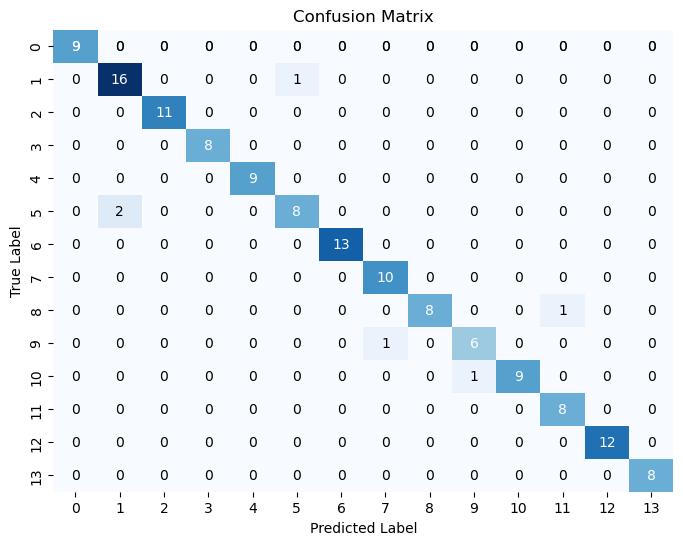

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.89      0.94      0.91        17
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         9
           5       0.89      0.80      0.84        10
           6       1.00      1.00      1.00        13
           7       0.91      1.00      0.95        10
           8       1.00      0.89      0.94         9
           9       0.86      0.86      0.86         7
          10       1.00      0.90      0.95        10
          11       0.89      1.00      0.94         8
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00         8

    accuracy                           0.96       141
   macro avg       0.96      0.96      0.96       141
weighted avg       0.96      0.96      0.96       141



In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Assuming X and y are defined earlier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the best hyperparameters obtained from the grid search
best_params = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

# Build an SVM model with the best hyperparameters
best_svm_model = SVC(**best_params)
best_svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_svm_model.predict(X_test)

# # Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=best_svm_model.classes_, yticklabels=best_svm_model.classes_)

for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[0])):
        if i == j:
            plt.text(j + 0.5, i + 0.5, str(conf_matrix[i, j]), ha='center', va='center', color='white')
        else:
            plt.text(j + 0.5, i + 0.5, str(conf_matrix[i, j]), ha='center', va='center', color='black')
            
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Assuming X and y are defined earlier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the SVM classifier
svm_classifier = SVC()

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 200, 300],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', .001, .01, 0.1, 1, 10]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)

# Get the best model
best_svm_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_svm_model.predict(X_test)

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Best Hyperparameters:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.89      0.94      0.91        17
           2       1.00      1.00      1.00        11
           3       1.00      0.88      0.93         8
           4       1.00      1.00      1.00         9
           5       0.89      0.80      0.84        10
           6       1.00      1.00      1.00        13
           7       0.91      1.00      0.95        10
           8       0.89      0.89      0.89         9
           9       0.86      0.86      0.86         7
          10       1.00      0.90      0.95        10
          11       0.89      1.00      0.94         8
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00         8

    accuracy                           0.95       141
   macro avg       0.95      0.95      0.95 

# ANN

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming you have your data in x_d and y_d
X = x_d
y = y_d

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the ANN model
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(14, activation='softmax')  # 14 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.05)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print('\nTest accuracy:', test_acc)




Epoch 1/100


17/17 [==============================] - 2s 26ms/step - loss: 2.2872 - accuracy: 0.3021 - val_loss: 1.5020 - val_accuracy: 0.7586
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 1.3725 - accuracy: 0.6567 - val_loss: 0.8655 - val_accuracy: 0.8276
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.8887 - accuracy: 0.7749 - val_loss: 0.6453 - val_accuracy: 0.8966
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6157 - accuracy: 0.8612 - val_loss: 0.4983 - val_accuracy: 0.8966
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 0.4583 - accuracy: 0.8931 - val_loss: 0.4114 - val_accuracy: 0.8966
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.3491 - accuracy: 0.9156 - val_loss: 0.3772 - val_accuracy: 0.8621
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2739 - accuracy: 0.9493 - val_loss: 0.3327 - val_accuracy: 0.9310
Epoch 8

17/17 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.2978 - val_accuracy: 0.9310
Epoch 52/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2945 - val_accuracy: 0.9310
Epoch 53/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2963 - val_accuracy: 0.9310
Epoch 54/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.2997 - val_accuracy: 0.9310
Epoch 55/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.3008 - val_accuracy: 0.9310
Epoch 56/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3007 - val_accuracy: 0.9310
Epoch 57/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.3026 - val_accuracy: 0.9310
Epoch 58/100
17/17 

In [47]:
# test_predictions = model.predict(X_test_scaled)
# predicted_labels = np.argmax(test_predictions, axis=1)
# np.savetxt('test_predictions.csv', np.hstack((predicted_labels.reshape(-1, 1), y_test.reshape(-1,1))), delimiter=',', fmt='%d')
# # np.savetxt('actual labels.csv', y_test.reshape(-1,1), delimiter=',', fmt='%d')

## Feature Selection PCA

In [48]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def apply_pca_for_feature_selection(X, desired_variance_ratio):
    pca = PCA(n_components=desired_variance_ratio)
    reduced_features = pca.fit_transform(X)
    return reduced_features, pca

def pca(X, y, test_size=0.2, random_state=42):

    variance_ratios = [i / 1000 for i in range(990, 1000)]
    max_accuracy = 0.0
    best_selected_features = None
    best_pca_model = None

    for desired_variance_ratio in variance_ratios:
        reduced_features, pca_model = apply_pca_for_feature_selection(X, desired_variance_ratio)
        print(f"var: {desired_variance_ratio}")
        print(np.shape(reduced_features))

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Standardize the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Build the ANN model
        model = keras.Sequential([
            keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(14, activation='softmax')  # 14 output classes
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.05)

        # Evaluate the model on the test set
        test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
        print('\nTest accuracy:', test_acc)

        # Update max accuracy and store corresponding features
        if test_acc > max_accuracy:
            max_accuracy = test_acc
            best_selected_features = reduced_features.copy()
            best_pca_model = pca_model

    # Apply inverse_transform to the full dataset with the best selected features
    trimmed_x_d = best_pca_model.inverse_transform(best_selected_features)

    return best_selected_features, max_accuracy

# Example usage:
reduced_x_d, max_accuracy = pca(x_d, y_d)
print(f"Best Accuracy: {max_accuracy}")
print("Trimmed x_d with Best Selected Features:")
print(np.shape(reduced_x_d))

var: 0.99
(703, 206)
Epoch 1/100
17/17 [==============================] - 1s 21ms/step - loss: 2.3243 - accuracy: 0.2833 - val_loss: 1.7626 - val_accuracy: 0.5172
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 1.4160 - accuracy: 0.6304 - val_loss: 1.1442 - val_accuracy: 0.7586
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 0.9458 - accuracy: 0.7580 - val_loss: 0.8160 - val_accuracy: 0.7586
Epoch 4/100
17/17 [==============================] - 0s 6ms/step - loss: 0.6589 - accuracy: 0.8274 - val_loss: 0.6118 - val_accuracy: 0.8621
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 0.4831 - accuracy: 0.8799 - val_loss: 0.4818 - val_accuracy: 0.8276
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.3628 - accuracy: 0.9193 - val_loss: 0.4064 - val_accuracy: 0.8621
Epoch 7/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2851 - accuracy: 0.9493 - val_loss: 0.3669 - val_accuracy

17/17 [==============================] - 0s 5ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.3583 - val_accuracy: 0.9310
Epoch 59/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.3574 - val_accuracy: 0.9310
Epoch 60/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.3606 - val_accuracy: 0.9310
Epoch 61/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.3616 - val_accuracy: 0.9310
Epoch 62/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.3581 - val_accuracy: 0.9310
Epoch 63/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3610 - val_accuracy: 0.9310
Epoch 64/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3634 - val_accuracy: 0.9310
Epoch 65/100
17/17 

17/17 [==============================] - 0s 6ms/step - loss: 0.0647 - accuracy: 0.9906 - val_loss: 0.2121 - val_accuracy: 0.9310
Epoch 15/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0532 - accuracy: 0.9981 - val_loss: 0.2381 - val_accuracy: 0.9310
Epoch 16/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0443 - accuracy: 1.0000 - val_loss: 0.2178 - val_accuracy: 0.9310
Epoch 17/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0380 - accuracy: 1.0000 - val_loss: 0.2188 - val_accuracy: 0.9310
Epoch 18/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0323 - accuracy: 1.0000 - val_loss: 0.2209 - val_accuracy: 0.9310
Epoch 19/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0284 - accuracy: 1.0000 - val_loss: 0.2168 - val_accuracy: 0.9310
Epoch 20/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.2072 - val_accuracy: 0.9310
Epoch 21/100
17/17 

Epoch 72/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2394 - val_accuracy: 0.9310
Epoch 73/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2426 - val_accuracy: 0.9310
Epoch 74/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2407 - val_accuracy: 0.9310
Epoch 75/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2422 - val_accuracy: 0.9310
Epoch 76/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2426 - val_accuracy: 0.9310
Epoch 77/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.2423 - val_accuracy: 0.9310
Epoch 78/100
17/17 [==============================] - 0s 5ms/step - loss: 9.7697e-04 - accuracy: 1.0000 - val_loss: 0.2437 - val_accuracy: 0.9310
Ep

17/17 [==============================] - 0s 6ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.4281 - val_accuracy: 0.9310
Epoch 29/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.4282 - val_accuracy: 0.9655
Epoch 30/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.4295 - val_accuracy: 0.9310
Epoch 31/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.4353 - val_accuracy: 0.9310
Epoch 32/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.4344 - val_accuracy: 0.9310
Epoch 33/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.4390 - val_accuracy: 0.9310
Epoch 34/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.4352 - val_accuracy: 0.9310
Epoch 35/100
17/17 

17/17 [==============================] - 0s 6ms/step - loss: 8.3919e-04 - accuracy: 1.0000 - val_loss: 0.4941 - val_accuracy: 0.9310
Epoch 86/100
17/17 [==============================] - 0s 6ms/step - loss: 8.1937e-04 - accuracy: 1.0000 - val_loss: 0.4944 - val_accuracy: 0.9310
Epoch 87/100
17/17 [==============================] - 0s 6ms/step - loss: 7.9473e-04 - accuracy: 1.0000 - val_loss: 0.4978 - val_accuracy: 0.9310
Epoch 88/100
17/17 [==============================] - 0s 6ms/step - loss: 7.7480e-04 - accuracy: 1.0000 - val_loss: 0.4974 - val_accuracy: 0.9310
Epoch 89/100
17/17 [==============================] - 0s 5ms/step - loss: 7.5462e-04 - accuracy: 1.0000 - val_loss: 0.4976 - val_accuracy: 0.9310
Epoch 90/100
17/17 [==============================] - 0s 5ms/step - loss: 7.3696e-04 - accuracy: 1.0000 - val_loss: 0.4971 - val_accuracy: 0.9310
Epoch 91/100
17/17 [==============================] - 0s 5ms/step - loss: 7.1613e-04 - accuracy: 1.0000 - val_loss: 0.4982 - val_accuracy

17/17 [==============================] - 0s 5ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.4138 - val_accuracy: 0.9310
Epoch 42/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.4208 - val_accuracy: 0.9310
Epoch 43/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.4256 - val_accuracy: 0.9310
Epoch 44/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.4270 - val_accuracy: 0.9310
Epoch 45/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4228 - val_accuracy: 0.9310
Epoch 46/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4268 - val_accuracy: 0.9310
Epoch 47/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.4324 - val_accuracy: 0.9310
Epoch 48/100
17/17 

17/17 [==============================] - 0s 5ms/step - loss: 6.2647e-04 - accuracy: 1.0000 - val_loss: 0.4791 - val_accuracy: 0.9310
Epoch 99/100
17/17 [==============================] - 0s 5ms/step - loss: 6.0976e-04 - accuracy: 1.0000 - val_loss: 0.4790 - val_accuracy: 0.9310
Epoch 100/100
5/5 [==============================] - 0s 4ms/step - loss: 0.8955 - accuracy: 0.9078

Test accuracy: 0.9078013896942139
var: 0.994
(703, 242)
Epoch 1/100
17/17 [==============================] - 1s 21ms/step - loss: 2.3289 - accuracy: 0.3246 - val_loss: 1.6095 - val_accuracy: 0.5862
Epoch 2/100
17/17 [==============================] - 0s 5ms/step - loss: 1.4464 - accuracy: 0.5966 - val_loss: 1.1104 - val_accuracy: 0.6897
Epoch 3/100
17/17 [==============================] - 0s 5ms/step - loss: 0.9901 - accuracy: 0.7073 - val_loss: 0.8714 - val_accuracy: 0.6897
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.7208 - accuracy: 0.8086 - val_loss: 0.6981 - val_accuracy: 0.8276


Epoch 55/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2956 - val_accuracy: 0.9310
Epoch 56/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.2963 - val_accuracy: 0.9310
Epoch 57/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.2941 - val_accuracy: 0.9310
Epoch 58/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2976 - val_accuracy: 0.9310
Epoch 59/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.2962 - val_accuracy: 0.9310
Epoch 60/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2993 - val_accuracy: 0.9310
Epoch 61/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2978 - val_accuracy: 0.9310
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 0.1218 - accuracy: 0.9850 - val_loss: 0.2480 - val_accuracy: 0.9655
Epoch 12/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0999 - accuracy: 0.9925 - val_loss: 0.2436 - val_accuracy: 0.9310
Epoch 13/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0813 - accuracy: 0.9944 - val_loss: 0.2298 - val_accuracy: 0.9655
Epoch 14/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0670 - accuracy: 0.9944 - val_loss: 0.2214 - val_accuracy: 0.9655
Epoch 15/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0552 - accuracy: 0.9981 - val_loss: 0.2308 - val_accuracy: 0.9655
Epoch 16/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0479 - accuracy: 1.0000 - val_loss: 0.2279 - val_accuracy: 0.9310
Epoch 17/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0399 - accuracy: 1.0000 - val_loss: 0.2255 - val_accuracy: 0.9310
Epoch 18/100
17/17 

Epoch 69/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2600 - val_accuracy: 0.9310
Epoch 70/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2607 - val_accuracy: 0.9310
Epoch 71/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2620 - val_accuracy: 0.9310
Epoch 72/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2635 - val_accuracy: 0.9310
Epoch 73/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2616 - val_accuracy: 0.9310
Epoch 74/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2623 - val_accuracy: 0.9310
Epoch 75/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.2628 - val_accuracy: 0.9310
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.3303 - val_accuracy: 0.8966
Epoch 26/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.3314 - val_accuracy: 0.8966
Epoch 27/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 0.3405 - val_accuracy: 0.8966
Epoch 28/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.3339 - val_accuracy: 0.8966
Epoch 29/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.3369 - val_accuracy: 0.8966
Epoch 30/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.3404 - val_accuracy: 0.8966
Epoch 31/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.3422 - val_accuracy: 0.8966
Epoch 32/100
17/17 

17/17 [==============================] - 0s 5ms/step - loss: 8.7350e-04 - accuracy: 1.0000 - val_loss: 0.3995 - val_accuracy: 0.8966
Epoch 83/100
17/17 [==============================] - 0s 5ms/step - loss: 8.4834e-04 - accuracy: 1.0000 - val_loss: 0.3978 - val_accuracy: 0.8966
Epoch 84/100
17/17 [==============================] - 0s 5ms/step - loss: 8.2622e-04 - accuracy: 1.0000 - val_loss: 0.3986 - val_accuracy: 0.8966
Epoch 85/100
17/17 [==============================] - 0s 5ms/step - loss: 8.0745e-04 - accuracy: 1.0000 - val_loss: 0.3991 - val_accuracy: 0.8966
Epoch 86/100
17/17 [==============================] - 0s 5ms/step - loss: 7.8531e-04 - accuracy: 1.0000 - val_loss: 0.4017 - val_accuracy: 0.8966
Epoch 87/100
17/17 [==============================] - 0s 5ms/step - loss: 7.6538e-04 - accuracy: 1.0000 - val_loss: 0.4016 - val_accuracy: 0.8966
Epoch 88/100
17/17 [==============================] - 0s 5ms/step - loss: 7.4781e-04 - accuracy: 1.0000 - val_loss: 0.4022 - val_accuracy

17/17 [==============================] - 0s 5ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.2138 - val_accuracy: 0.9310
Epoch 39/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2091 - val_accuracy: 0.9310
Epoch 40/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2184 - val_accuracy: 0.9310
Epoch 41/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.2103 - val_accuracy: 0.9310
Epoch 42/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.2115 - val_accuracy: 0.9310
Epoch 43/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.2165 - val_accuracy: 0.9310
Epoch 44/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.2189 - val_accuracy: 0.9310
Epoch 45/100
17/17 

17/17 [==============================] - 0s 5ms/step - loss: 7.1390e-04 - accuracy: 1.0000 - val_loss: 0.2464 - val_accuracy: 0.9310
Epoch 96/100
17/17 [==============================] - 0s 5ms/step - loss: 6.9757e-04 - accuracy: 1.0000 - val_loss: 0.2467 - val_accuracy: 0.9310
Epoch 97/100
17/17 [==============================] - 0s 4ms/step - loss: 6.8029e-04 - accuracy: 1.0000 - val_loss: 0.2475 - val_accuracy: 0.9310
Epoch 98/100
17/17 [==============================] - 0s 5ms/step - loss: 6.6534e-04 - accuracy: 1.0000 - val_loss: 0.2477 - val_accuracy: 0.9310
Epoch 99/100
17/17 [==============================] - 0s 5ms/step - loss: 6.5189e-04 - accuracy: 1.0000 - val_loss: 0.2483 - val_accuracy: 0.9310
Epoch 100/100
5/5 [==============================] - 0s 3ms/step - loss: 1.0035 - accuracy: 0.9149

Test accuracy: 0.914893627166748
var: 0.998
(703, 320)
Epoch 1/100
17/17 [==============================] - 1s 20ms/step - loss: 2.2233 - accuracy: 0.3265 - val_loss: 1.3063 - val_acc

Epoch 52/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.3634 - val_accuracy: 0.9310
Epoch 53/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.3604 - val_accuracy: 0.9310
Epoch 54/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.3631 - val_accuracy: 0.9310
Epoch 55/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3649 - val_accuracy: 0.9310
Epoch 56/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.3662 - val_accuracy: 0.9310
Epoch 57/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.3650 - val_accuracy: 0.9310
Epoch 58/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.3665 - val_accuracy: 0.9310
Epoch 

17/17 [==============================] - 0s 5ms/step - loss: 0.2915 - accuracy: 0.9268 - val_loss: 0.3804 - val_accuracy: 0.8966
Epoch 9/100
17/17 [==============================] - 0s 5ms/step - loss: 0.2328 - accuracy: 0.9437 - val_loss: 0.3438 - val_accuracy: 0.9310
Epoch 10/100
17/17 [==============================] - 0s 5ms/step - loss: 0.1867 - accuracy: 0.9625 - val_loss: 0.3388 - val_accuracy: 0.9310
Epoch 11/100
17/17 [==============================] - 0s 5ms/step - loss: 0.1489 - accuracy: 0.9794 - val_loss: 0.3128 - val_accuracy: 0.9310
Epoch 12/100
17/17 [==============================] - 0s 6ms/step - loss: 0.1210 - accuracy: 0.9794 - val_loss: 0.3162 - val_accuracy: 0.9310
Epoch 13/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0977 - accuracy: 0.9906 - val_loss: 0.3129 - val_accuracy: 0.9310
Epoch 14/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0812 - accuracy: 0.9906 - val_loss: 0.3320 - val_accuracy: 0.9310
Epoch 15/100
17/17 [

Epoch 66/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3162 - val_accuracy: 0.9655
Epoch 67/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.3163 - val_accuracy: 0.9655
Epoch 68/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.3151 - val_accuracy: 0.9655
Epoch 69/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.3161 - val_accuracy: 0.9655
Epoch 70/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.3165 - val_accuracy: 0.9655
Epoch 71/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3157 - val_accuracy: 0.9655
Epoch 72/100
17/17 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.3175 - val_accuracy: 0.9655
Epoch 

## ANN Tuning

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

X = reduced_x_d
y = y_d

# # Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Flatten())

        # Tune the number of layers.
        for i in range(hp.Int("num_layers", 1, 3)):
            model.add(
                layers.Dense(
                    # Tune number of units separately.
                    units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                    activation=hp.Choice(f"activation_{i}", ["relu", "tanh", "sigmoid"]),
                )
            )

        model.add(layers.Dense(14, activation="softmax")) # Output Classes

        learning_rate = hp.Choice("learning_rate", [0.001, 0.01, 0.1, 0.3, 0.5])
#         alpha = hp.Choice("alpha", [0.1, 0.3, 0.5, 0.7, 0.9])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate), #, momentum=alpha
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128]),
            **kwargs,
        )
    
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Create an instance of HyperParameters
hp = kt.HyperParameters()

# Build the model with default hyperparameters
my_hypermodel = MyHyperModel()
my_model = my_hypermodel.build(hp)

tuner = kt.Hyperband(
    hypermodel=my_hypermodel,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    directory="Parameter Tuning",
    project_name="Neural Network-14 zoomed",
    overwrite=True
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1, 0.3, 0.5], 'ordered': True}


In [50]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.05, callbacks=[stop_early])

Trial 186 Complete [00h 00m 06s]
val_accuracy: 0.13793103396892548

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 11m 41s


In [51]:
tuner.results_summary()

Results summary
Results in Parameter Tuning\Neural Network-14 zoomed
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0128 summary
Hyperparameters:
num_layers: 1
units_0: 64
activation_0: relu
learning_rate: 0.1
units_1: 320
activation_1: relu
units_2: 32
activation_2: sigmoid
batch_size: 128
tuner/epochs: 7
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 1.0

Trial 0137 summary
Hyperparameters:
num_layers: 1
units_0: 64
activation_0: relu
learning_rate: 0.1
units_1: 320
activation_1: relu
units_2: 32
activation_2: sigmoid
batch_size: 128
tuner/epochs: 13
tuner/initial_epoch: 7
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 0128
Score: 1.0

Trial 0144 summary
Hyperparameters:
num_layers: 1
units_0: 64
activation_0: relu
learning_rate: 0.1
units_1: 320
activation_1: relu
units_2: 32
activation_2: sigmoid
batch_size: 128
tuner/epochs: 25
tuner/initial_epoch: 13
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0137
Score: 1.0

Trial 0148 summary


In [68]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units_0')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.05, callbacks=[early_stopping])

# Check Result
eval_result = model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

# # Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.
# val_acc_per_epoch = history.history['val_accuracy']
# best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
# print('Best epoch:', best_epoch)

# # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
# hypermodel = tuner.hypermodel.build(best_hps)

# # Retrain the model
# hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.1)

# # Check Result
# eval_result = hypermodel.evaluate(X_test, y_test)
# print("[test loss, test accuracy]:", eval_result)


Epoch 1/100
17/17 [==============================] - 1s 18ms/step - loss: 1.3469 - accuracy: 0.6173 - val_loss: 0.5222 - val_accuracy: 0.8621
Epoch 2/100
17/17 [==============================] - 0s 4ms/step - loss: 0.3052 - accuracy: 0.9006 - val_loss: 0.2236 - val_accuracy: 0.9310
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.1499 - accuracy: 0.9625 - val_loss: 0.6420 - val_accuracy: 0.8621
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 0.1468 - accuracy: 0.9625 - val_loss: 0.1072 - val_accuracy: 0.9655
Epoch 5/100
17/17 [==============================] - 0s 6ms/step - loss: 0.0990 - accuracy: 0.9869 - val_loss: 0.7635 - val_accuracy: 0.8621
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.1984 - accuracy: 0.9756 - val_loss: 0.1507 - val_accuracy: 0.9655
Epoch 7/100
17/17 [==============================] - 0s 6ms/step - loss: 0.1385 - accuracy: 0.9719 - val_loss: 0.2091 - val_accuracy: 0.9310
Epoch 8/100
